In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.1

# EDA
- Statistics of train and test images
- Statistics of label distribution
- Check image set formats

In [2]:
import os

train_img_dir = '/kaggle/input/2425-ii-ait-3002-2-object-detection/Dataset/Train/images'
train_label_dir = '/kaggle/input/2425-ii-ait-3002-2-object-detection/Dataset/Train/labels'
test_img_dir = '/kaggle/input/2425-ii-ait-3002-2-object-detection/Dataset/Test/images'

train_images = os.listdir(train_img_dir)
train_labels = os.listdir(train_label_dir)
test_images = os.listdir(test_img_dir)

print(f"train images: {len(train_images)}")
print(f"labels files: {len(train_labels)}")
print(f"test images: {len(test_images)}")

train images: 7631
labels files: 7631
test images: 848


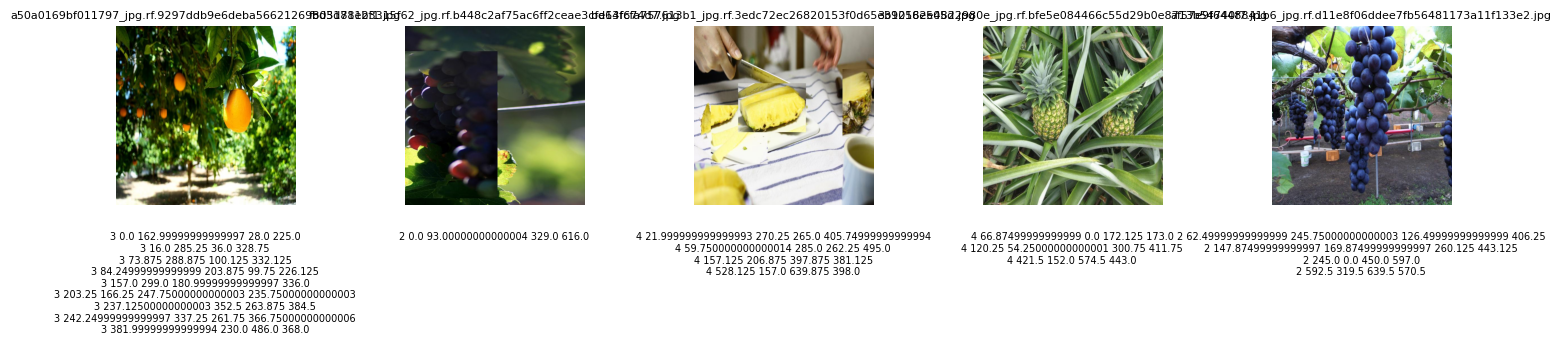

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_files = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_files = image_files[:5]  

plt.figure(figsize=(15, 6)) 

for i, filename in enumerate(image_files):
    image_path = os.path.join(train_img_dir, filename)
    label_name = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(train_label_dir, label_name)

    img = Image.open(image_path)

    label_text = ""
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label_text = f.read().strip()
    else:
        label_text = "No label found"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(filename, fontsize=8)
    plt.axis('off')

    plt.text(0.5, -0.15, label_text, fontsize=7, ha='center', va='top', transform=plt.gca().transAxes, wrap=True)

plt.tight_layout()
plt.show()


In [4]:
import glob

label_files = glob.glob(train_label_dir +'/*.txt')
all_classes = set()

for lbl_path in label_files:
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            cls = int(line.strip().split()[0])
            all_classes.add(cls)

num_classes = len(all_classes)
sorted_classes = sorted(list(all_classes))
print(f"The number of lables: {num_classes}")
print(f"Labels list: {sorted_classes}")


The number of lables: 6
Labels list: [0, 1, 2, 3, 4, 5]


In [5]:
from collections import Counter

label_counts = Counter()
for label_file in train_labels:
    with open(os.path.join(train_label_dir , label_file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            cls_id = line.strip().split()[0]
            label_counts[cls_id] += 1

for cls_id, count in sorted(label_counts.items()):
    print(f"Class {cls_id}: {count} bbox")


Class 0: 6299 bbox
Class 1: 3166 bbox
Class 2: 6489 bbox
Class 3: 13724 bbox
Class 4: 1419 bbox
Class 5: 1720 bbox


In [6]:
import os
from PIL import Image
from collections import defaultdict

def check_image_sizes(folder_path):
    size_counts = defaultdict(int)
    corrupted_files = []

    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if not os.path.isfile(filepath):
            continue
        try:
            with Image.open(filepath) as img:
                size = img.size  # (width, height)
                size_counts[size] += 1
        except Exception as e:
            corrupted_files.append(filename)

    for size, count in size_counts.items():
        print(f"  {size[0]}x{size[1]}: {count}")

check_image_sizes(train_img_dir)

  640x640: 7631


## Using the Yolo model for the fruit recognition problem
- High accuracy on many types of objects: YOLO is one of the modern object detection models that can recognize many different types of objects with high accuracy -> suitable for distinguishing many types of fruits with different shapes and colors in images.
- Effective processing on images with many small objects: YOLO is capable of accurately classifying these small objects thanks to a dense partitioning grid and a design suitable for multi-object detection.
- Compact, easy-to-deploy model: suitable for limited training resources
- Short processing time helps speed up the image processing pipeline

## Survey of YOLO models 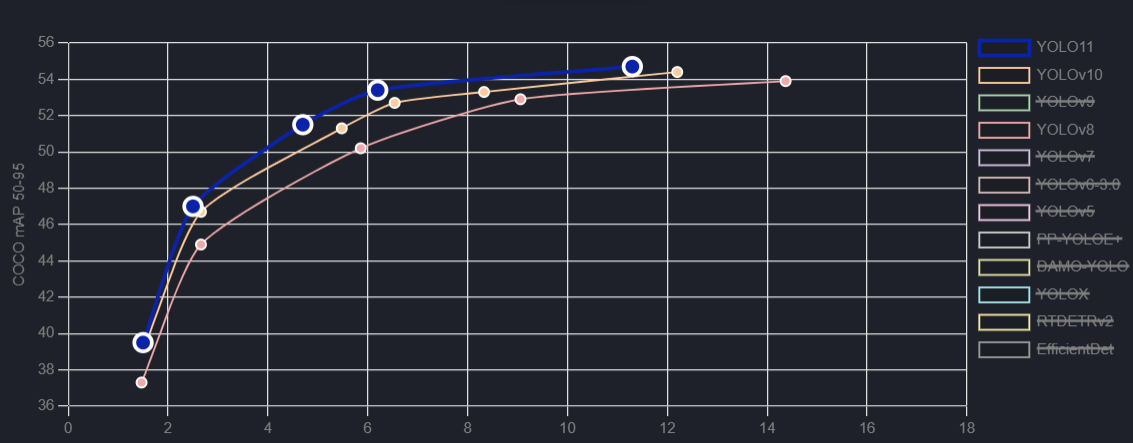

### Choose yolov11
- Outstanding performance (mAP) at the same computational level. The graph shows that YOLOv11 consistently achieves higher accuracy than all previous versions in the same FLOPs segment
- yolo11 is capable of detecting small objects well thanks to its strong backbone architecture and head improvements.
- Better speed optimization on GPU: YOLOv11 is well compatible with TensorRT, allowing for extremely fast inference speed on GPU.
- The mAP by FLOPs graph shows that YOLOv11 has a smooth performance increase curve, indicating high reliability and effective model scalability

## Analysis of YOLOv11 versions
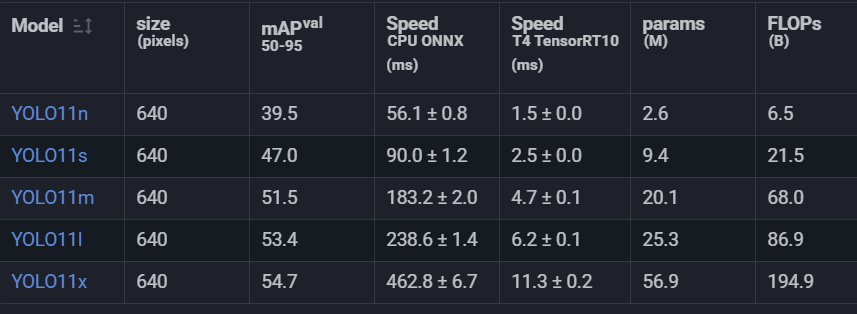

### Choose to use the yolo11l version
- Optimal balance between performance and computational cost:
YOLOv11-l achieves mAP = 53.4 with FLOPs = 86.9B, only slightly lower than YOLOv11-x (54.7) but twice as fast in processing time (6.2ms vs 11.3ms).
- Suitable for mid-range GPUs with speed and resources YOLOv11-l is very suitable for deployment on the current GPU Tesla T4
- With high mAP and good small object recognition, YOLOv11-l is very suitable for fruits with similar shapes such as apples - pears, oranges - tangerines, or hidden fruits.
- Using only 25.3 million parameters and saving 100B FLOPs compared to YOLOv11-x, saving resources while still ensuring nearly equivalent accuracy.
- Conclusion: yolov11l achieves a balance of speed and accuracy for problems requiring high accuracy and limited training resources

# Prepare data
- Normalize labels for yolo model
- Split data and create train, val folders according to YOLO's Dataset structure
- Create data_yaml configuration file for yolo

In [ ]:
import os

def convert_bbox(size, box):
    img_w, img_h = size
    x_min, y_min, x_max, y_max = box
    x_center = (x_min + x_max) / 2.0 / img_w
    y_center = (y_min + y_max) / 2.0 / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return x_center, y_center, w, h

def convert_label_file(input_path, output_path, img_size):
    with open(input_path, 'r') as f_in, open(output_path, 'w') as f_out:
        for line in f_in:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            class_id = parts[0]
            x_min, y_min, x_max, y_max = map(float, parts[1:5])
            x_center, y_center, w, h = convert_bbox(img_size, (x_min, y_min, x_max, y_max))
            f_out.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

def batch_convert_labels(input_dir, output_dir, img_size):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.endswith('.txt'):
            convert_label_file(
                os.path.join(input_dir, filename),
                os.path.join(output_dir, filename),
                img_size
            )



img_width = 640
img_height = 640
    
output_label_folder = '/kaggle/working/labels'
os.makedirs(train_label_dir, exist_ok=True)

batch_convert_labels(train_label_dir, output_label_folder, (img_width, img_height))


In [ ]:
import os
import random
import shutil


train_lbl_dir = '/kaggle/working/labels'

base_dir = '/kaggle/working/Dataset'
image_train_dir = os.path.join(base_dir, 'images/train')
image_val_dir = os.path.join(base_dir, 'images/val')
label_train_dir = os.path.join(base_dir, 'labels/train')
label_val_dir = os.path.join(base_dir, 'labels/val')

os.makedirs(image_train_dir, exist_ok=True)
os.makedirs(image_val_dir, exist_ok=True)
os.makedirs(label_train_dir, exist_ok=True)
os.makedirs(label_val_dir, exist_ok=True)

all_images = [f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.png'))]
val_split = 0.1
val_images = set(random.sample(all_images, int(len(all_images) * val_split)))

for img in all_images:
    lbl = img.rsplit('.', 1)[0] + '.txt'
    src_img = os.path.join(train_img_dir, img)
    src_lbl = os.path.join(train_lbl_dir, lbl)
    
    if img in val_images:
        shutil.copy(src_img, os.path.join(image_val_dir, img))
        shutil.copy(src_lbl, os.path.join(label_val_dir, lbl))
    else:
        shutil.copy(src_img, os.path.join(image_train_dir, img))
        shutil.copy(src_lbl, os.path.join(label_train_dir, lbl))


In [ ]:
data_yaml = """\
train: /kaggle/working/Dataset/images/train
val: /kaggle/working/Dataset/images/val

nc: 6
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']
"""

with open('/kaggle/working/Dataset/data.yaml', 'w') as f:
    f.write(data_yaml)


 # Training model

## Train the model with the first 100epochs
- Train_data - test_data ratio is 0.9 - 0.1
- epochs=100: Train the model in 100 epochs.
- imgsz=640: Input image size is 640x640 pixels.
- batch=8: Batch size is 8 images per gradient update.
- workers=4: Use 4 threads to load data in parallel.
- optimizer='AdamW': Using the AdamW optimizer helps to better control the optimization process and weight decay.
- lr0=0.0001: Initial learning rate is 0.0001.
- lrf=0.005: Final learning rate after linear decay is 0.005 × lr0.
- weight_decay=0.0005: Regularization coefficient to reduce overfitting.
- warmup_epochs=3: Number of epochs to start warmup to avoid large gradients causing instability in the early stages.
- warmup_momentum=0.8: Momentum value in the warmup stage helps stabilize weight updates.
- box=7.5: Weight for Bounding Box Loss, emphasizing on predicting accurate box coordinates.
- cls=0.5: Weight for Classification Loss, affecting classification accuracy.
- dfl=1.5: Weight for Distribution Focal Loss, helping to improve coordinate prediction accuracy.
- augment=True: Enable data augmentation (rotate, crop, change brightness...) to increase data diversity.
- save=True: Save model weights during training.
- save_period=10: Save checkpoints every 10 epochs.
- patience=20: If no improvement after 20 epochs → early stopping.
- verbose=True: Show full log during training.

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
from ultralytics import YOLO
from IPython.display import Image

model = YOLO('yolo11l.pt')

results = model.train(
    data='/kaggle/working/Dataset/data.yaml',
    epochs=100,
    imgsz=640,
    batch=8,
    workers=4,
    optimizer='AdamW',
    lr0=0.0001,
    lrf=0.005, #learningrate final
    save=True,
    save_period=10,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    box=7.5, #Bounding Box Loss Weigh
    cls=0.5, #Classification Loss Weight
    dfl=1.5, #Distribution Focal Loss Weight
    augment=True,
    patience=20,
    verbose=True  
)
    

## Model Evaluation Based on Plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("runs/detect/train/results.csv")
df.columns = df.columns.str.strip()  
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Mean Average Precision over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("runs/detect/train/results.csv")
df.columns = df.columns.str.strip() 

plt.figure(figsize=(12, 6))

plt.plot(df['epoch'], df['train/box_loss'], label='train_box_loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='train_cls_loss')
plt.plot(df['epoch'], df['metrics/precision(B)'], label='precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')

plt.xlabel('Epoch')
plt.ylabel('Loss / Metric')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Train the model for 50 more epochs with the entire data
- Take the best model after 100 epochs and continue training for 50 more epochs with the entire training data

In [ ]:
full_data_yaml = """\
train: /kaggle/working/Dataset/images/train
val: /kaggle/working/Dataset/images/val

nc: 6
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']
"""

with open('/kaggle/working/Dataset/full_data.yaml', 'w') as f:
    f.write(full_data_yaml)


In [ ]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

results = model.train(
    data='/kaggle/working/Dataset/full_data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.001,
    patience=20,
    device=0  
)